In [2]:
import numpy as np
import pandas as pd
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
#!pip install openpyxl

In [4]:
#!pip install statsmodels

In [5]:
df= pd.read_excel('AirQualityUCi.xlsx')

In [6]:
df.describe()

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
count,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000,9357.000000
mean,-34.207524,1048.869652,-159.090093,1.865576,894.475963,168.604200,794.872333,58.135898,1391.363266,974.951534,9.776600,39.483611,-6.837604
std,77.657170,329.817015,139.789093,41.380154,342.315902,257.424561,321.977031,126.931428,467.192382,456.922728,43.203438,51.215645,38.976670
min,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000,-200.000000
25%,0.600000,921.000000,-200.000000,4.004958,711.000000,50.000000,637.000000,53.000000,1184.750000,699.750000,10.950000,34.050000,0.692275
50%,1.500000,1052.500000,-200.000000,7.886653,894.500000,141.000000,794.250000,96.000000,1445.500000,942.000000,17.200000,48.550000,0.976823
75%,2.600000,1221.250000,-200.000000,13.636091,1104.750000,284.200000,960.250000,133.000000,1662.000000,1255.250000,24.075000,61.875000,1.296223
max,11.900000,2039.750000,1189.000000,63.741476,2214.000000,1479.000000,2682.750000,339.700000,2775.000000,2522.750000,44.600000,88.725000,2.231036


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   object        
 2   CO(GT)         9357 non-null   float64       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   int64         
 5   C6H6(GT)       9357 non-null   float64       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float64       
 13  RH             9357 non-null   float64       
 14  AH             9357 non-null   float64       
dtypes: datetime64[ns](1),

## Combine date and Time for the Time Series dataset

In [8]:
df['Datetime']= pd.to_datetime(df.Date.astype(str)+' '+df.Time.astype(str))
df = df.set_index(df['Datetime'])
df.head(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
Datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,2004-03-10 18:00:00
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,2004-03-10 19:00:00


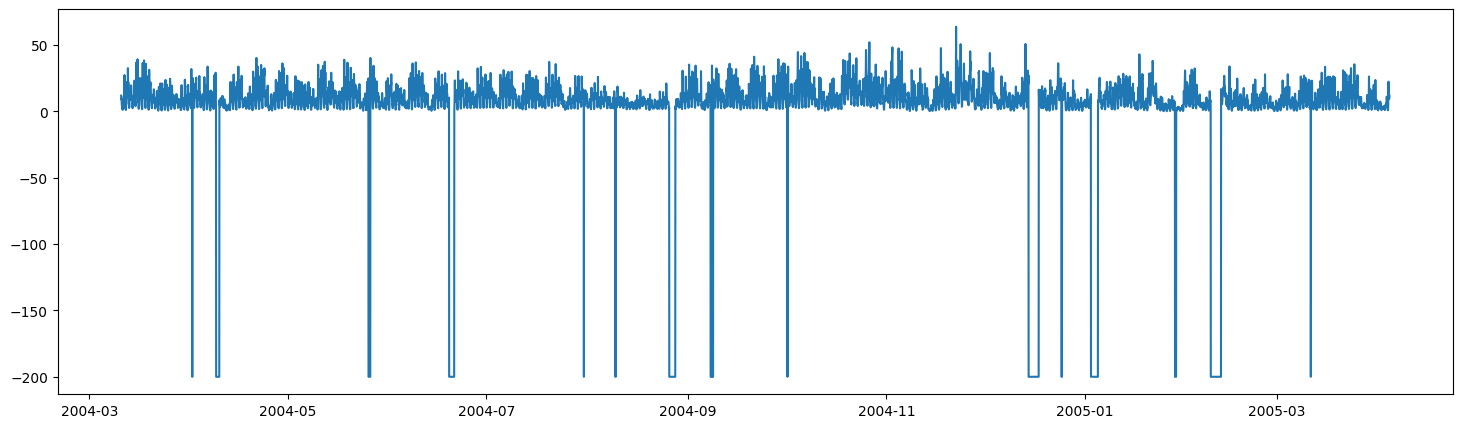

In [9]:
plt.figure(figsize=(18,5))
plt.plot(df['C6H6(GT)'])
#plt.gcf().autofmt_xdate()
plt.show()

## identifying outlier data points relative to some norm or usual signal.
## outliers either needs to be cleaned or they indicate an unusual event

-10.441741809244842 28.082791045690655


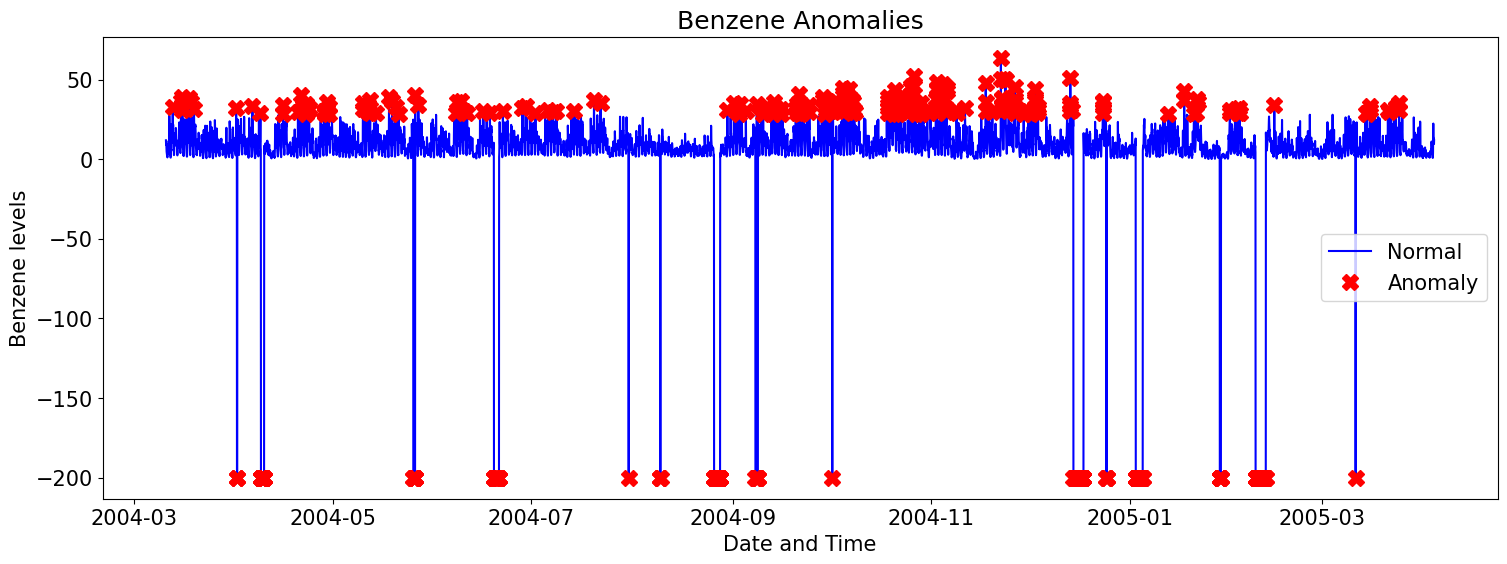

In [130]:
df_anomaly=pd.DataFrame()
#df_anomaly=np.where((df['C6H6(GT)'] <= lower_val) & (df['C6H6(GT)'] >= upper_val))
# Calculate IQR for temperature
q1_pc1, q3_pc1 = df['C6H6(GT)'].quantile([0.25, 0.75])
iqr_pc1 = q3_pc1 - q1_pc1
# Calculate upper and lower bounds for outlier for pc1
lower_pc1 = q1_pc1 - (1.5*iqr_pc1)
upper_pc1 = q3_pc1 + (1.5*iqr_pc1)
# Filter out the outliers from the pc1
df_anomaly['anomaly_T'] = ((df['C6H6(GT)']>upper_pc1) | (df['C6H6(GT)']<lower_pc1)).astype('float')
# Calculate IQR for the 2nd principal component (pc2)
q1_pc2, q3_pc2 = df['C6H6(GT)'].quantile([0.25, 0.75])
iqr_pc2 = q3_pc2 - q1_pc2
# Calculate upper and lower bounds for outlier for pc2
lower_val = q1_pc2 - (1.5*iqr_pc2)
upper_val = q3_pc2 + (1.5*iqr_pc2)
print(lower_val, upper_val)
df_anomaly=df.copy()
# Filter out the outliers from the pc2
df_anomaly['anomaly_T'] = ((df['C6H6(GT)']>upper_val) | (df['C6H6(GT)']<lower_val)).astype('float')
# Let's plot the outliers from pc1 on top of the sensor_11 and see where they occured in the time series
a = df_anomaly[df_anomaly['anomaly_T'] == 1] #anomaly
_ = plt.figure(figsize=(18,6))
_ = plt.plot(df_anomaly['C6H6(GT)'], color='blue', label='Normal')
_ = plt.plot(a['C6H6(GT)'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
_ = plt.xlabel('Date and Time')
_ = plt.ylabel('Benzene levels')
_ = plt.title('Benzene Anomalies')
_ = plt.legend(loc='best')
plt.show();



## Find rows/dates and times when the temp was -200

In [131]:
df_anomaly=np.where((df['C6H6(GT)'] <= lower_val) & (df['C6H6(GT)'] >= upper_val))
df_anomaly=pd.DataFrame(df_anomaly)
df_anomaly

""
0


## updating the anamolus data as temp cannot be -200

In [132]:

df.loc[df["C6H6(GT)"] <=lower_val, "C6H6(GT)"] = df['C6H6(GT)'].mean()
df.loc[df["C6H6(GT)"] >=upper_val, "C6H6(GT)"] = df['C6H6(GT)'].mean()

In [133]:
df

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
Datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.600,48.875001,0.757754,2004-03-10 18:00:00
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.300,47.700000,0.725487,2004-03-10 19:00:00
2004-03-10 20:00:00,2004-03-10,20:00:00,2.2,1402.00,88,8.997817,939.25,131.0,1140.00,114.0,1554.50,1074.00,11.900,53.975000,0.750239,2004-03-10 20:00:00
2004-03-10 21:00:00,2004-03-10,21:00:00,2.2,1375.50,80,9.228796,948.25,172.0,1092.00,122.0,1583.75,1203.25,11.000,60.000000,0.786713,2004-03-10 21:00:00
2004-03-10 22:00:00,2004-03-10,22:00:00,1.6,1272.25,51,6.518224,835.50,131.0,1205.00,116.0,1490.00,1110.00,11.150,59.575001,0.788794,2004-03-10 22:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,2005-04-04,10:00:00,3.1,1314.25,-200,13.529605,1101.25,471.7,538.50,189.8,1374.25,1728.50,21.850,29.250000,0.756824,2005-04-04 10:00:00
2005-04-04 11:00:00,2005-04-04,11:00:00,2.4,1162.50,-200,11.355157,1027.00,353.3,603.75,179.2,1263.50,1269.00,24.325,23.725000,0.711864,2005-04-04 11:00:00
2005-04-04 12:00:00,2005-04-04,12:00:00,2.4,1142.00,-200,12.374538,1062.50,293.0,603.25,174.7,1240.75,1092.00,26.900,18.350000,0.640649,2005-04-04 12:00:00


In [134]:
#df['T'].ffill().add(df['T'].bfill()).div(2)
df.loc[(df['C6H6(GT)']<lower_val)]

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
Datetime,,,,,,,,,,,,,,,,


In [135]:
df.head(2)

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Datetime
Datetime,,,,,,,,,,,,,,,,
2004-03-10 18:00:00,2004-03-10,18:00:00,2.6,1360.00,150,11.881723,1045.50,166.0,1056.25,113.0,1692.00,1267.50,13.6,48.875001,0.757754,2004-03-10 18:00:00
2004-03-10 19:00:00,2004-03-10,19:00:00,2.0,1292.25,112,9.397165,954.75,103.0,1173.75,92.0,1558.75,972.25,13.3,47.700000,0.725487,2004-03-10 19:00:00


## ensuring all dates and hour are represented in the data

In [136]:
df.drop([ 'Date','Time', 'Datetime'], axis=1, inplace=True)

In [137]:
df=df.sort_values(['Datetime']).apply(lambda x:x.fillna(method='ffill'))

## Check if any rows with NaN under an entire DataFrame

In [138]:
df[df.isna().any(axis=1)]

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,,


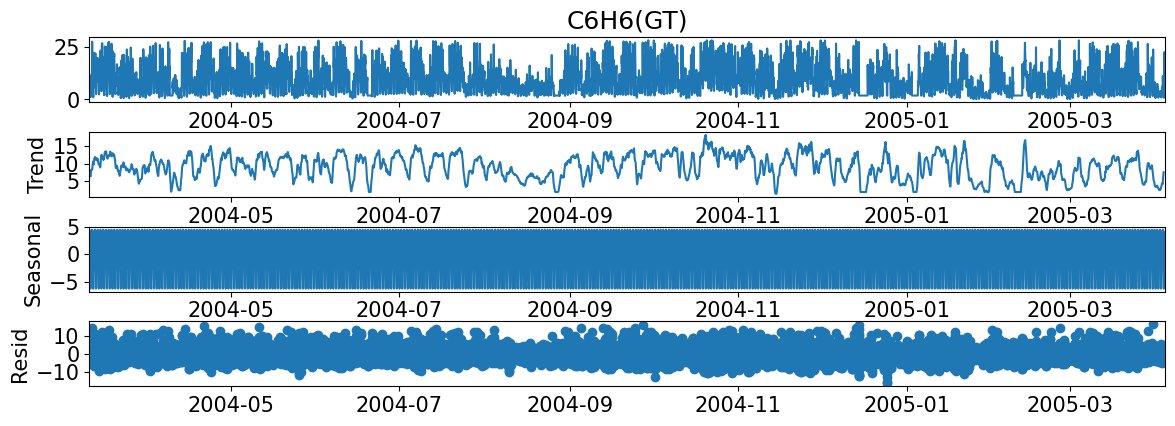

In [139]:
import statsmodels.api as sm
seas_d=sm.tsa.seasonal_decompose(df["C6H6(GT)"],model='add');
fig=seas_d.plot()
fig.set_figheight(4)
plt.show()

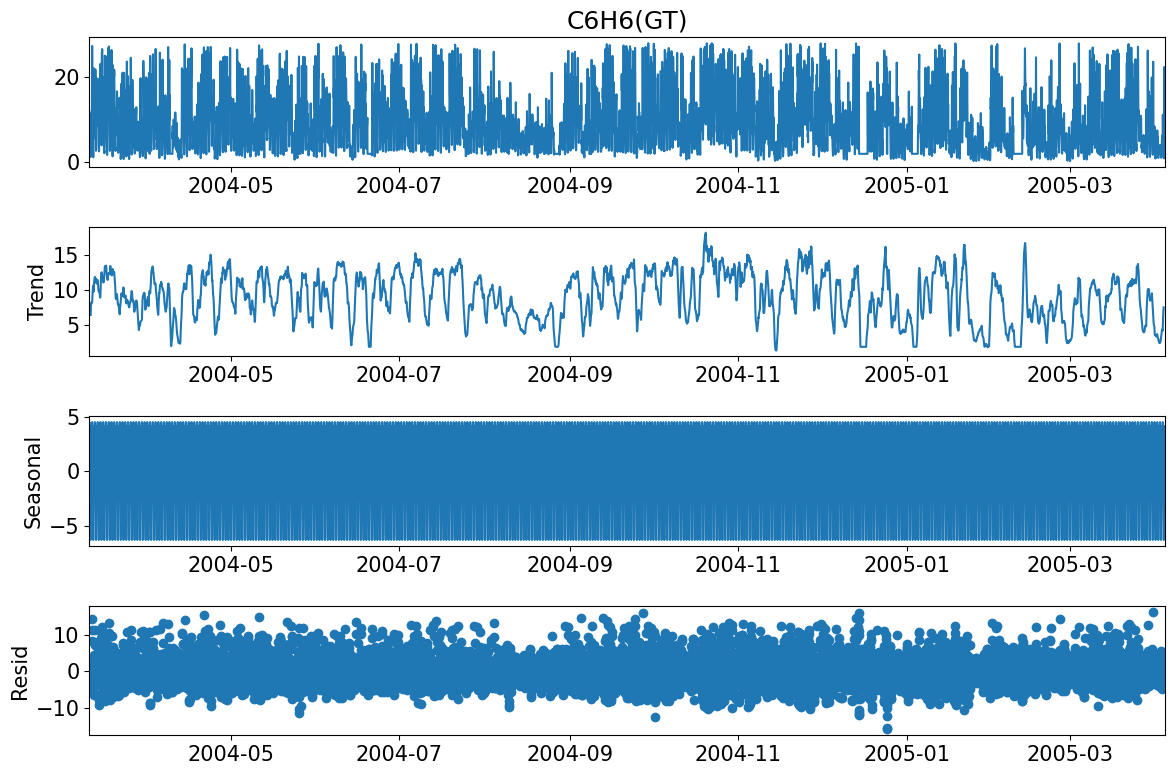

In [140]:
plt.rc('figure',figsize=(12,8))
plt.rc('font',size=15)
result = sm.tsa.seasonal_decompose(df["C6H6(GT)"],model='additive')
fig = result.plot()

In [141]:
from sklearn.preprocessing import MinMaxScaler
sc_in = MinMaxScaler(feature_range=(0, 1))
df_scaled = sc_in.fit_transform(df.loc[:,df.columns!='DateTime'])
df_scaled =pd.DataFrame(df_scaled, columns=df.columns)


In [142]:
df_scaled

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,0.956111,0.696506,0.251980,0.421131,0.515949,0.217987,0.435782,0.579952,0.635966,0.538977,0.873262,0.861979,0.992715
1,0.953280,0.666257,0.224622,0.331951,0.478355,0.180465,0.476541,0.541041,0.591176,0.430539,0.872036,0.857910,0.992555
2,0.954224,0.715258,0.207343,0.317617,0.471935,0.197141,0.464834,0.581805,0.589748,0.467909,0.866312,0.879643,0.992678
3,0.954224,0.703427,0.201584,0.325907,0.475663,0.221560,0.448183,0.596628,0.599580,0.515380,0.862633,0.900511,0.992858
4,0.951392,0.657328,0.180706,0.228614,0.428956,0.197141,0.487382,0.585510,0.568067,0.481131,0.863246,0.899039,0.992868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9352,0.958471,0.676080,0.000000,0.480280,0.539043,0.400060,0.256179,0.722253,0.529160,0.708291,0.906991,0.794008,0.992710
9353,0.955168,0.608327,0.000000,0.402231,0.508285,0.329541,0.278814,0.702613,0.491933,0.539528,0.917110,0.774872,0.992488
9354,0.955168,0.599174,0.000000,0.438820,0.522991,0.293627,0.278640,0.694275,0.484286,0.474520,0.927637,0.756256,0.992136
9355,0.953752,0.536890,0.000000,0.337336,0.480737,0.258785,0.312722,0.659070,0.417143,0.356166,0.933463,0.739631,0.991509


In [143]:
df_scaled['Datetime']= df.index
#df_scaled.index=df.index
X=df_scaled
X = X.set_index(X['Datetime'])
X=X.drop(['Datetime'], axis=1)
X

,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
Datetime,,,,,,,,,,,,,
2004-03-10 18:00:00,0.956111,0.696506,0.251980,0.421131,0.515949,0.217987,0.435782,0.579952,0.635966,0.538977,0.873262,0.861979,0.992715
2004-03-10 19:00:00,0.953280,0.666257,0.224622,0.331951,0.478355,0.180465,0.476541,0.541041,0.591176,0.430539,0.872036,0.857910,0.992555
2004-03-10 20:00:00,0.954224,0.715258,0.207343,0.317617,0.471935,0.197141,0.464834,0.581805,0.589748,0.467909,0.866312,0.879643,0.992678
2004-03-10 21:00:00,0.954224,0.703427,0.201584,0.325907,0.475663,0.221560,0.448183,0.596628,0.599580,0.515380,0.862633,0.900511,0.992858
2004-03-10 22:00:00,0.951392,0.657328,0.180706,0.228614,0.428956,0.197141,0.487382,0.585510,0.568067,0.481131,0.863246,0.899039,0.992868
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2005-04-04 10:00:00,0.958471,0.676080,0.000000,0.480280,0.539043,0.400060,0.256179,0.722253,0.529160,0.708291,0.906991,0.794008,0.992710
2005-04-04 11:00:00,0.955168,0.608327,0.000000,0.402231,0.508285,0.329541,0.278814,0.702613,0.491933,0.539528,0.917110,0.774872,0.992488
2005-04-04 12:00:00,0.955168,0.599174,0.000000,0.438820,0.522991,0.293627,0.278640,0.694275,0.484286,0.474520,0.927637,0.756256,0.992136


In [144]:
X= df.drop(["C6H6(GT)"], axis=1)
y= df["C6H6(GT)"]
X.columns

Index(['CO(GT)', 'PT08.S1(CO)', 'NMHC(GT)', 'PT08.S2(NMHC)', 'NOx(GT)',
       'PT08.S3(NOx)', 'NO2(GT)', 'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH',
       'AH'],
      dtype='object')

In [145]:
split_date="11-09-2004"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [178]:
base_model= xgb.XGBRegressor(n_estimators=100, max_depth=4,early_stopping_rounds=100)
base_model.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       
       verbose=50)

[0]	validation_0-rmse:7.80780	validation_1-rmse:6.94944
[50]	validation_0-rmse:0.05440	validation_1-rmse:0.16377
[99]	validation_0-rmse:0.03437	validation_1-rmse:0.14586


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [179]:
y_pred = base_model.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
standard_score = mean_squared_error(y_test, base_model.predict(X_test), squared=False)
print('RMSE_Standard_Model:', standard_score)

RMSE_Standard_Model: 0.14585538568978837


In [185]:
xgb_1=xgb.XGBRegressor(
              early_stopping_rounds=100,
             
             eval_metric='rmse',
              max_depth=3, 
             min_child_weight=4.0,  
             n_estimators=1000)
xgb_1.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=50)

xgb_1_score = mean_squared_error(y_test, xgb_1.predict(X_test), squared=False)
print('RMSE_best parame_Model:', xgb_1_score)

[0]	validation_0-rmse:7.84971	validation_1-rmse:6.98185
[50]	validation_0-rmse:0.10031	validation_1-rmse:0.16676
[100]	validation_0-rmse:0.05561	validation_1-rmse:0.13493
[150]	validation_0-rmse:0.03970	validation_1-rmse:0.12460
[200]	validation_0-rmse:0.03100	validation_1-rmse:0.12101
[250]	validation_0-rmse:0.02528	validation_1-rmse:0.11931
[300]	validation_0-rmse:0.02196	validation_1-rmse:0.11829
[350]	validation_0-rmse:0.01976	validation_1-rmse:0.11745
[400]	validation_0-rmse:0.01798	validation_1-rmse:0.11715
[450]	validation_0-rmse:0.01645	validation_1-rmse:0.11655
[500]	validation_0-rmse:0.01502	validation_1-rmse:0.11597
[550]	validation_0-rmse:0.01360	validation_1-rmse:0.11554
[600]	validation_0-rmse:0.01231	validation_1-rmse:0.11507
[650]	validation_0-rmse:0.01152	validation_1-rmse:0.11489
[700]	validation_0-rmse:0.01077	validation_1-rmse:0.11434
[750]	validation_0-rmse:0.01011	validation_1-rmse:0.11402
[800]	validation_0-rmse:0.00956	validation_1-rmse:0.11369
[850]	validation_

## Feature Importance

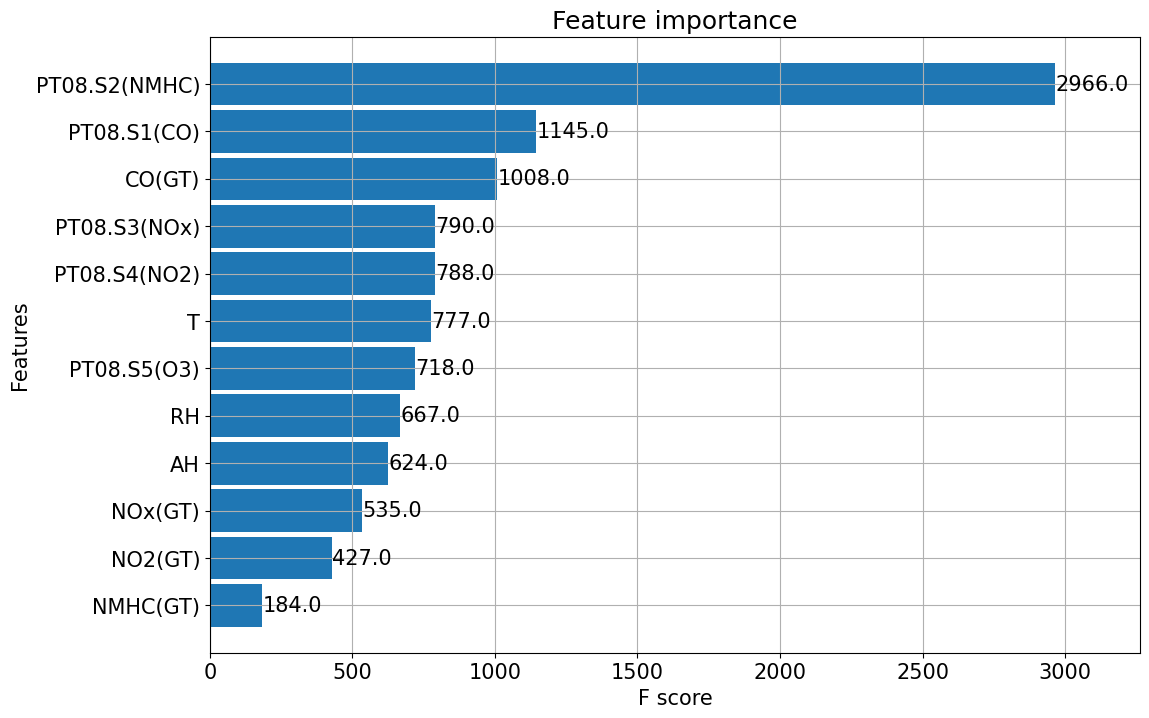

In [83]:
_=plot_importance(base_model, height=0.9)

In [84]:
sorted_idx = np.argsort(base_model.feature_importances_)[::-1]
X_selected_cols=pd.DataFrame()
for index in sorted_idx:
    if base_model.feature_importances_[index]>0:
        X_selected_cols[X_train.columns[index]]= X_train[X_train.columns[index]]
        print([X_train.columns[index], base_model.feature_importances_[index]]) 

['PT08.S2(NMHC)', 0.999125]
['PT08.S3(NOx)', 0.0007075966]
['RH', 3.5084828e-05]
['PT08.S1(CO)', 3.3349792e-05]
['T', 2.9182182e-05]
['NO2(GT)', 1.3407091e-05]
['AH', 1.23708505e-05]
['PT08.S5(O3)', 1.1628127e-05]
['NMHC(GT)', 9.525855e-06]
['PT08.S4(NO2)', 9.491864e-06]
['NOx(GT)', 9.098547e-06]
['CO(GT)', 4.3153223e-06]


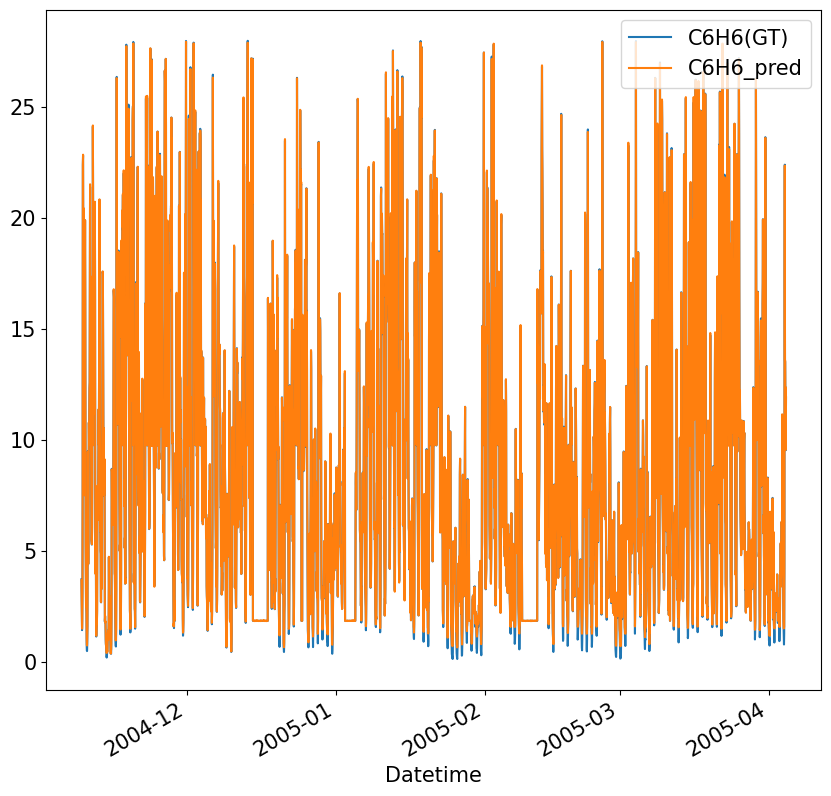

In [85]:
X_test['C6H6_pred']= base_model.predict(X_test)
X_test["C6H6(GT)"]=y_test
df_X= pd.concat([X_test, X_train], sort=False)
_=df_X[[ "C6H6(GT)", 'C6H6_pred',]].plot(figsize=(10,10))

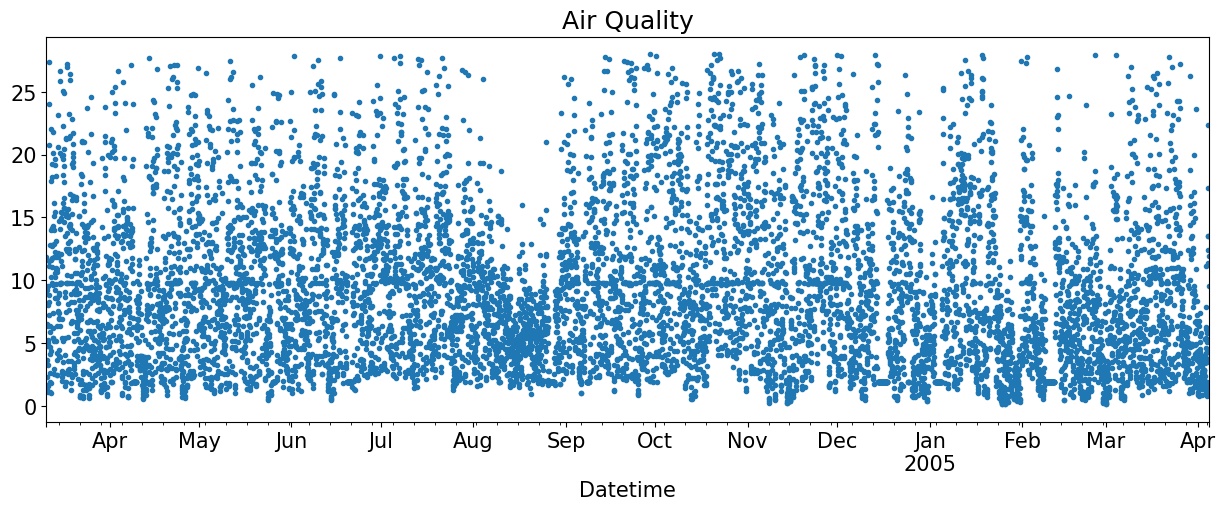

In [31]:
plt_air = df['C6H6(GT)'].plot(style='.', figsize=(15,5), title='Air Quality')

## Hyperparameter tuning

In [32]:
split_date="11-09-2004"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [33]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
#Import 'scope' from hyperopt in order to obtain int values for certain hyperparameters.
from hyperopt.pyll.base import scope
hyperparameter_grid={'max_depth': scope.int(hp.quniform("max_depth", 1, 10, 1)),
        'gamma': hp.uniform ('gamma', 1,9),
        'reg_alpha' : hp.quniform('reg_alpha', 40,180,1),
        'reg_lambda' : hp.uniform('reg_lambda', 0,1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5,1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'eta': hp.uniform('eta', 0,1),            
        'seed': 0
    }


In [34]:
def objective(space):
    '''params={'n_estimators': space['n_estimators'], 
            'max_depth' : int(space['max_depth']), 
            'gamma' : space['gamma'],
            'reg_alpha' : int(space['reg_alpha']),
            'min_child_weight':int(space['min_child_weight']),
            'colsample_bytree':int(space['colsample_bytree'])}
   '''
    model = xgb.XGBRegressor(**space, early_stopping_rounds=100,  eval_metric="rmse")
    
    #Define evaluation datasets.
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    #Fit the model. Define evaluation sets, early_stopping_rounds, and eval_metric.
    model.fit(X_train, y_train,
            eval_set=evaluation,
            verbose=False)
    
  

    pred = model.predict(X_test)
    mse= mean_squared_error(y_test, pred)
    print ("SCORE:", mse)
    #change the metric if you like
    return {'loss':mse, 'status': STATUS_OK, 'model': model}


In [35]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = hyperparameter_grid,
                        algo = tpe.suggest,
                        max_evals = 500,
                        trials = trials)

SCORE:                                                                          
0.7087032429763481                                                              
SCORE:                                                                          
1.3091766145786923                                                              
SCORE:                                                                          
5.260075692060354                                                               
SCORE:                                                                          
2.1520987615646257                                                              
SCORE:                                                                          
1.285693291572938                                                               
SCORE:                                                                          
10.715547538219331                                                              
SCORE:                      

SCORE:                                                                          
0.49719570789413536                                                             
SCORE:                                                                          
75.66502957473364                                                               
SCORE:                                                                          
0.3649267411739311                                                              
SCORE:                                                                          
0.7324968879800939                                                              
SCORE:                                                                          
0.28749284645778533                                                             
SCORE:                                                                          
0.5809433793027383                                                              
SCORE:                      

SCORE:                                                                          
0.2907743030446146                                                              
SCORE:                                                                          
0.7260633742296102                                                              
SCORE:                                                                          
0.25466763215902255                                                             
SCORE:                                                                          
0.35727890562233333                                                             
SCORE:                                                                          
2.144412567496398                                                               
SCORE:                                                                          
0.9534398466481373                                                              
SCORE:                      

SCORE:                                                                          
0.8845137080807551                                                              
SCORE:                                                                          
1.0693559255553107                                                              
SCORE:                                                                          
0.41172672625241197                                                             
SCORE:                                                                          
0.5225467137070255                                                              
SCORE:                                                                          
0.7146985875904667                                                              
SCORE:                                                                          
0.21495015890494823                                                             
SCORE:                      

SCORE:                                                                          
0.9115330589231693                                                              
SCORE:                                                                          
0.28697987401231656                                                             
SCORE:                                                                          
0.1692847011725303                                                              
SCORE:                                                                          
0.22939544484736182                                                             
SCORE:                                                                          
85.79662590545254                                                               
SCORE:                                                                          
0.2763261897637669                                                              
SCORE:                      

In [36]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.9531996388767773, 'eta': 0.035989158186997196, 'gamma': 6.285575536065164, 'max_depth': 3.0, 'min_child_weight': 4.0, 'reg_alpha': 58.0, 'reg_lambda': 0.530007209919871}


In [60]:
for i in range(len(trials.results)):
    print(trials.results[i]['loss'], trials.results[i]['model'])

0.7087032429763481 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.7983640086805857, early_stopping_rounds=100,
             enable_categorical=False, eta=0.15126119870862753,
             eval_metric='rmse', feature_types=None, gamma=5.394368175730008,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=5.0, missing=nan, monotone_constraints=None,
             n_estimators=180, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)
1.3091766145786923 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6746938381684826, early_st

In [61]:
#Create instace of best model.
best_model = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['model']
lowest_loss = trials.results[np.argmin([r['loss'] for r in 
    trials.results])]['loss']

#Examine model hyperparameters
print(best_model, lowest_loss)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9531996388767773, early_stopping_rounds=100,
             enable_categorical=False, eta=0.035989158186997196,
             eval_metric='rmse', feature_types=None, gamma=6.285575536065164,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4.0, missing=nan, monotone_constraints=None,
             n_estimators=180, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...) 0.1692847011725303


In [38]:
xgb_preds_best = best_model.predict(X_test)
xgb_score_best = mean_squared_error(y_test, xgb_preds_best, squared=False)
print('RMSE_Best_Model:', xgb_score_best)

xgb_standard = xgb.XGBRegressor().fit(X_train, y_train)
standard_score = mean_squared_error(y_test, xgb_standard.predict(X_test), squared=False)
print('RMSE_Standard_Model:', standard_score)

RMSE_Best_Model: 0.4114422209405961
RMSE_Standard_Model: 0.11414659524762966


In [78]:
xgb_1=xgb.XGBRegressor(
             colsample_bytree=0.9531996388767773, early_stopping_rounds=200,
             enable_categorical=False, eta=0.035989158186997196,
             eval_metric='rmse',  gamma=6.285575536065164,
              max_depth=3, 
             min_child_weight=4.0,  
             n_estimators=1000)
xgb_1.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
       verbose=50)

xgb_1_score = mean_squared_error(y_test, xgb_1.predict(X_test), squared=False)
print('RMSE_best parame_Model:', xgb_1_score)

[0]	validation_0-rmse:10.74392	validation_1-rmse:9.56779
[50]	validation_0-rmse:1.84174	validation_1-rmse:1.67453
[100]	validation_0-rmse:0.40424	validation_1-rmse:0.49125
[150]	validation_0-rmse:0.19837	validation_1-rmse:0.33782
[200]	validation_0-rmse:0.18830	validation_1-rmse:0.34040
[250]	validation_0-rmse:0.18821	validation_1-rmse:0.34212
[300]	validation_0-rmse:0.18820	validation_1-rmse:0.34240
[350]	validation_0-rmse:0.18820	validation_1-rmse:0.34244
[356]	validation_0-rmse:0.18820	validation_1-rmse:0.34244
RMSE_best parame_Model: 0.3329877044362622


In [39]:
X_test['T_pred']= xgb_preds_best
X_test['T']=y_test
df_X= pd.concat([X_test, X_train], sort=False)

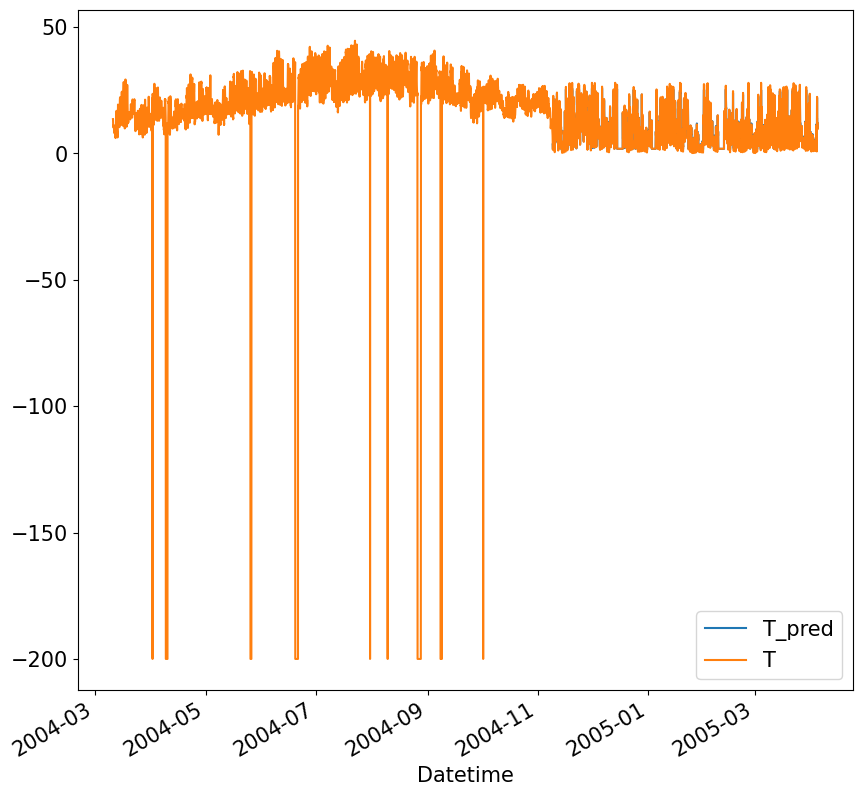

In [40]:
_=df_X[['T_pred', 'T']].plot(figsize=(10,10))

In [91]:
split_date="11-09-2004"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [92]:
n=5000
params = {

    'max_depth':int(best_hyperparams['max_depth']),
    'min_child_weight': int(best_hyperparams['min_child_weight']),
    'eta':best_hyperparams['eta'],
    
    'colsample_bytree': best_hyperparams['colsample_bytree'],
    'gamma':best_hyperparams['gamma'],
    'reg_alpha': best_hyperparams['reg_alpha'], 
    'reg_lambda': best_hyperparams['reg_lambda'],
    "objective": "reg:squarederror", 
    "tree_method": "hist",
    'eval_metric':'rmse',
    'n_estimators':1000,
}
#Define evaluation datasets.
evals = [(X_train, y_train), (X_test, y_test)]
model= xgb.XGBRegressor(**params,early_stopping_rounds=100)
model.fit(X_train, y_train,
            eval_set=evals,
            verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9531996388767773, early_stopping_rounds=100,
             enable_categorical=False, eta=0.035989158186997196,
             eval_metric='rmse', feature_types=None, gamma=6.285575536065164,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

In [93]:
y_pred = model.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
standard_score = mean_squared_error(y_test, model.predict(X_test), squared=False)
print('RMSE_Standard_Model:', standard_score)

RMSE_Standard_Model: 0.6820716586729774


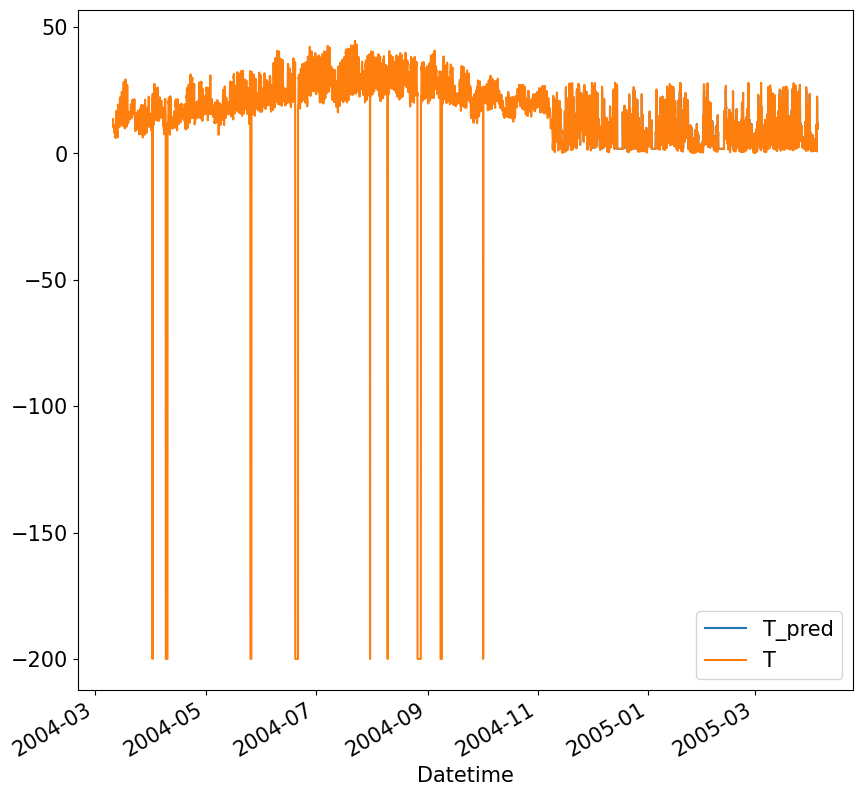

In [94]:
X_test['T_pred']= y_pred
X_test['T']=y_test
df_X= pd.concat([X_test, X_train], sort=False)
_=df_X[['T_pred', 'T']].plot(figsize=(10,10))

In [95]:
split_date="11-09-2004"
X_train=X.loc[X.index <=split_date].copy()
y_train=y.loc[y.index <=split_date].copy()
X_test=X.loc[X.index >split_date].copy()
y_test=y.loc[y.index >split_date].copy()

In [ ]:
X_test['C6H6_pred']= base_model.predict(X_test)
X_test["C6H6(GT)"]=y_test
df_X= pd.concat([X_test, X_train], sort=False)
_=df_X[[ "C6H6(GT)", 'C6H6_pred',]].plot(figsize=(10,10))

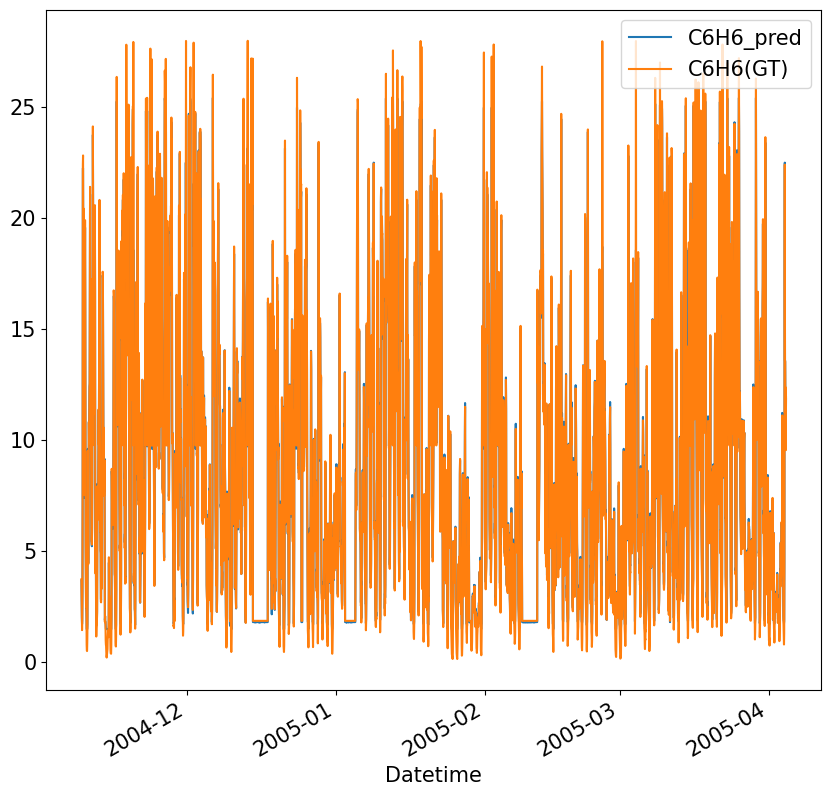

In [96]:
X_test['C6H6_pred']= model.predict(X_test)
X_test["C6H6(GT)"]=y_test
df_X= pd.concat([X_test, X_train], sort=False)
_=df_X[['C6H6_pred', 'C6H6(GT)']].plot(figsize=(10,10))